# The following Class is used to normalize the solar inputs based on the longitude, latitude, cell type and capacity, tilt, asmuth, and the specific day of the year.

In [29]:
import numpy as np

class Preprocess:
    def __init__(self, latitude, longitude):
        """
            Latitude in degrees (+ north, - south)
            Longitude in degrees (+ east, - west)
        """
        self.latitude = latitude
        self.longitude = longitude

    def H_prime(self, day_of_year):
        """
        day_of_year: int (1-365 or 366)
        This is the average solar constant adjusted for the day of the year. 
        It is used to approximate the solar irradiation when there is no clouds and the sun is at a normal angle.
        """
        H0 = 1367 # W/m² (average solar constant)
        H0_prime = H0 * (1 + 0.033 * np.cos(np.radians(360 * day_of_year / 365)))
        return H0_prime
    def estimate_solar_irradiation(self, day_of_year, hour_local, tilt_deg=28, azimuth_deg=220):
        """Estimate solar irradiation (W/m²) on a tilted surface.
        day_of_year: int (1-365 or 366)
        hour_local: local time in hours, e.g., 13.5 = 1:30 PM
        tilt_deg: tilt angle of the panel from horizontal (degrees), 0° = horizontal
        azimuth_deg: azimuth angle of the panel (degrees), 0° = North, 90° = East, 180° = South, 270° = West
        returns the estimated solar irradiation (W/m²)
        """
    
        # Get corrected solar constant
        H0 = self.H_prime(day_of_year)

        # Convert to radians
        phi = np.radians(self.latitude)
        tilt = np.radians(tilt_deg)
        azimuth = np.radians(azimuth_deg)

        # Solar declination angle (radians)
        delta = 23.45 * np.sin(np.radians(360/365 * (day_of_year - 81)))
        delta = np.radians(delta)

        # Equation of Time (minutes)
        # B = 360/365 * (day_of_year - 81) is the angle in degrees
        # EoT = 9.87 * sin(2B) - 7.53 * cos(B) - 1.5 * sin(B)
        # where B is in degrees
        # EoT is the difference between solar time and clock time
        # due to the elliptical shape of the Earth's orbit and axial tilt, 81st day of the year is around March 21st which is the equinox
        B = 360/365 * (day_of_year - 81)
        EoT = 9.87 * np.sin(np.radians(2*B)) - 7.53 * np.cos(np.radians(B)) - 1.5 * np.sin(np.radians(B))

        # Time correction factor (minutes)
        timezone_longitude = round(self.longitude / 15) * 15
        time_correction = 4 * (self.longitude - timezone_longitude) + EoT

        # Solar time (hours)
        solar_time = hour_local + time_correction / 60

        # Hour angle omega (radians)
        omega = np.radians(15 * (solar_time - 12))

        # Cosine of solar zenith angle (for reference)
        cosZ = np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(omega)
        cosZ = max(cosZ, 0)

        if cosZ == 0:
            return 0  # Sun is below horizon, no irradiation

        # Solar azimuth and solar elevation
        sin_alpha = np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(omega)  # sin of solar elevation angle
        alpha = np.arcsin(sin_alpha)  # solar elevation angle in radians

        # Solar azimuth angle (γs)
        cos_azimuth = (np.sin(delta) - np.sin(phi) * np.sin(alpha)) / (np.cos(phi) * np.cos(alpha))
        cos_azimuth = np.clip(cos_azimuth, -1, 1)  # numerical safety
        solar_azimuth = np.arccos(cos_azimuth)  # radians

        if omega > 0:  # afternoon
            solar_azimuth = 2*np.pi - solar_azimuth

        # Angle of incidence (θ) between sun rays and panel normal
        cos_theta = (
            np.sin(delta) * np.sin(phi) * np.cos(tilt)
            - np.sin(delta) * np.cos(phi) * np.sin(tilt) * np.cos(azimuth)
            + np.cos(delta) * np.cos(phi) * np.cos(tilt) * np.cos(omega)
            + np.cos(delta) * np.sin(phi) * np.sin(tilt) * np.cos(azimuth) * np.cos(omega)
            + np.cos(delta) * np.sin(tilt) * np.sin(azimuth) * np.sin(omega)
        )
        cos_theta = max(cos_theta, 0)  # No backside radiation

        # Estimate irradiation on tilted panel
        irradiation = H0 * cos_theta

        return irradiation


    def normalize(self, cell_type, num_panels, tilt_angle_deg, azimuth_deg, total_rated_capacity_kw):
        """
        Normalize the irradiation based on panel setup and system specs.

        Args:
            cell_type (str): Type of solar cell ('mono', 'poly', 'thinfilm')
            num_panels (int): Number of panels
            tilt_angle_deg (float): Tilt of the panels (degrees)
            azimuth_deg (float): Orientation of the panels (degrees from North)
            total_rated_capacity_kw (float): Total rated system capacity (kW)

        Returns:
            float: Normalized irradiation value (W/m²)
        """
        # Define typical efficiencies by cell type
        efficiencies = {
            'mono': 0.20,
            'poly': 0.17,
            'thinfilm': 0.11
        }

        # Get efficiency based on cell type
        cell_type = cell_type.lower()
        if cell_type not in efficiencies:
            raise ValueError(f"Unknown cell type '{cell_type}'. Choose from {list(efficiencies.keys())}.")
        
        efficiency = efficiencies[cell_type]

        # Calculate total panel area (in m²)
        total_rated_capacity_w = total_rated_capacity_kw * 1000  # convert kW to W
        total_area_m2 = total_rated_capacity_w / (efficiency * 1000)  # 1000 W/m² at STC

        # Irradiance normalized per m²
        normalized_irradiation = (total_rated_capacity_w / total_area_m2)  # Should give back 1000 W/m² ideally

        # Could include tilt and azimuth correction here later if needed

        return normalized_irradiation


# Create a Preprocess object for Metrit
pre = Preprocess(latitude=34.2599, longitude=-35.8419)
irradiation=np.zeros((360,12))
for day in range(0, 30, 1):
    for time in range(0, 12, 1):
        irradiation[day,time]=pre.estimate_solar_irradiation(day, time+6, tilt_deg=30, azimuth_deg=230)



In [27]:
irradiation2=np.zeros((30,12))
for day in range(0, 29, 1):
    for time in range(0, 12, 1):
        irradiation2[day,time]=pre.estimate_solar_irradiation(day+120, time+6, tilt_deg=30, azimuth_deg=230)
irradiation2=irradiation2.flatten()

In [5]:
import pandas as pd

# Load Excel file (should be .xlsx if it has multiple sheets)
file_path = 'Data.xlsx'  # Replace with the correct filename if necessary

# Load the second sheet (sheet index 1)
df_weather = pd.read_excel(file_path, sheet_name=1)
# Load the first sheet (sheet index 0)
df_PV_Out = pd.read_excel('Data.xlsx', sheet_name=0)
df_PV_Out = df_PV_Out.drop(columns=['Date','Hour'])
# Convert to NumPy array
data_array = df_PV_Out.to_numpy()

# Ensure 'period_end' is in datetime format
df_weather['period_end'] = pd.to_datetime(df_weather['period_end'])

# Filter rows where time is between 06:00 and 17:00
# filtered_df_weather = df[df['period_end'].dt.hour.between(6, 17)]
filtered_df_weather = df_weather[df_weather['period_end'].dt.hour.between(6, 17)].drop(columns='period_end')
X = np.column_stack((filtered_df_weather.to_numpy(), irradiation2))
# Display or process the filtered DataFrame
y=df_PV_Out.to_numpy()


Selected Features (mask): [ True  True False False False False False False  True False False False
 False False  True False False False  True  True  True False False  True
  True False False False False False False False False False False False
 False False]
R² score (refit): 0.20707689637129723

Selected Features and Coefficients:
Feature x0: Coefficient = 0.2912315187583285
Feature x0: Coefficient = -2.106795496513672
Feature x0: Coefficient = -0.26022884822837034
Feature x0: Coefficient = -0.6002685663581324
Feature x0: Coefficient = 0.16180842382406174
Feature x0: Coefficient = -0.6243962121587207
Feature x0: Coefficient = 1.0613386485930225
Feature x0: Coefficient = -0.19765247417753234
Feature x0: Coefficient = 0.3137866765615201

Regression Equation:
y = 0.291*x0 + -2.107*x0 + -0.260*x0 + -0.600*x0 + 0.162*x0 + -0.624*x0 + 1.061*x0 + -0.198*x0 + 0.314*x0


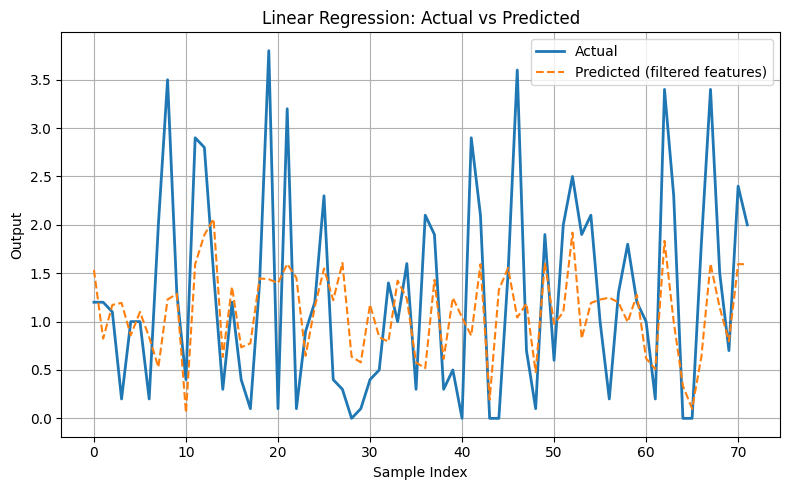

In [45]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Fit initial model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Step 2: Get mask of features with |coef| > 1e-1
coef_mask = np.abs(lr.coef_) > 1e-1
coef_mask2 = coef_mask  # Save original mask for later

# Ensure coef_mask is 1D
coef_mask = coef_mask.flatten()
print("Selected Features (mask):", coef_mask)

# Step 3: Filter X to keep only important features
X_train_filtered = X_train[:, coef_mask]
X_test_filtered = X_test[:, coef_mask]

# Step 4: Refit model using filtered features
lr_refit = LinearRegression()
lr_refit.fit(X_train_filtered, y_train)

# Step 5: Predict on test data
y_pred = lr_refit.predict(X_test_filtered)

# Optional: Evaluate performance
from sklearn.metrics import r2_score
print("R² score (refit):", r2_score(y_test, y_pred))

# Step 6: Print the selected coefficients and corresponding feature names
print("\nSelected Features and Coefficients:")
selected_features = np.where(coef_mask2)[0]  # Indices of the selected features from the original model
selected_coefs = lr.coef_[coef_mask2]       # The coefficients of the selected features from the initial model

# If you have feature names (e.g., columns of your DataFrame), use them here.
# Assuming X_train is a DataFrame with column names, you can replace `x{feature_idx}` with the actual names.

# If X_train is a NumPy array without feature names, it will print `x{feature_idx}`
# If you have names, make sure you pass them in `feature_names`.

try:
    feature_names = X_train.columns  # If using pandas DataFrame
    for feature_name, coef in zip(feature_names[selected_features], selected_coefs):
        print(f"{feature_name}: Coefficient = {coef}")
except AttributeError:
    # If X_train is a NumPy array without feature names
    for feature_idx, coef in zip(selected_features, selected_coefs):
        print(f"Feature x{feature_idx}: Coefficient = {coef}")

# Step 7: Display the regression equation
print("\nRegression Equation:")
if 'feature_names' in locals():
    equation = "y = " + " + ".join([f"{coef:.3f}*{name}" for name, coef in zip(feature_names[selected_features], selected_coefs)])
else:
    equation = "y = " + " + ".join([f"{coef:.3f}*x{idx}" for idx, coef in zip(selected_features, selected_coefs)])
print(equation)

# Step 8: Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted (filtered features)', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


R² score (refit): 0.20707689637129723

Selected Features and Coefficients:
air_temp: Coefficient = 0.2912315187583285
air_temp: Coefficient = -2.106795496513672
air_temp: Coefficient = -0.26022884822837034
air_temp: Coefficient = -0.6002685663581324
air_temp: Coefficient = 0.16180842382406174
air_temp: Coefficient = -0.6243962121587207
air_temp: Coefficient = 1.0613386485930225
air_temp: Coefficient = -0.19765247417753234
air_temp: Coefficient = 0.3137866765615201

Regression Equation:
y = 0.291*air_temp + -2.107*air_temp + -0.260*air_temp + -0.600*air_temp + 0.162*air_temp + -0.624*air_temp + 1.061*air_temp + -0.198*air_temp + 0.314*air_temp


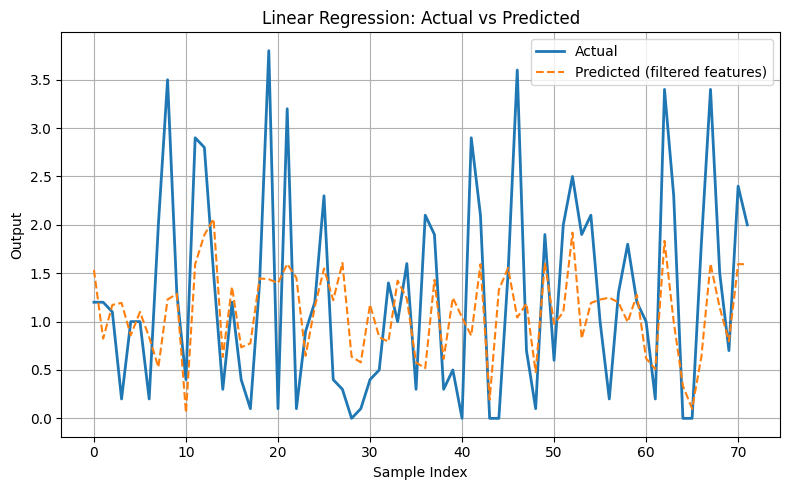

In [47]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Fit initial model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Step 2: Get mask of features with |coef| > 1e-1
coef_mask = np.abs(lr.coef_) > 1e-1
coef_mask2 = coef_mask  # Save original mask for later

# Ensure coef_mask is 1D
coef_mask = coef_mask.flatten()

# Step 3: Filter X to keep only important features
X_train_filtered = X_train[:, coef_mask]
X_test_filtered = X_test[:, coef_mask]

# Step 4: Refit model using filtered features
lr_refit = LinearRegression()
lr_refit.fit(X_train_filtered, y_train)

# Step 5: Predict on test data
y_pred = lr_refit.predict(X_test_filtered)

# Optional: Evaluate performance
from sklearn.metrics import r2_score
print("R² score (refit):", r2_score(y_test, y_pred))

# Step 6: Print the selected coefficients and corresponding feature names
print("\nSelected Features and Coefficients:")
selected_features = np.where(coef_mask2)[0]  # Indices of the selected features from the original model
selected_coefs = lr.coef_[coef_mask2]       # The coefficients of the selected features from the initial model

# Feature names as per the user's provided list
feature_names = [
    'air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti',
    'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate',
    'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop',
    'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m',
    'zenith', 'period_end', 'Perfect_irradiation'
]

# Display selected features and their corresponding coefficients
for feature_idx, coef in zip(selected_features, selected_coefs):
    print(f"{feature_names[feature_idx]}: Coefficient = {coef}")

# Step 7: Display the regression equation
print("\nRegression Equation:")
equation = "y = " + " + ".join([f"{coef:.3f}*{feature_names[idx]}" for idx, coef in zip(selected_features, selected_coefs)])
print(equation)

# Step 8: Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted (filtered features)', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# --- Step 1: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 2: Normalize Features ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Step 3: Build Model ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(100, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# --- Step 4: Compile ---
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# --- Step 5: Train with Validation ---
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1
)
# --- Step 6: Evaluate on Test Set ---
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"\nTest R² Score: {r2:.4f}")


Epoch 1/1000
8/8 [==============================] - 1s 30ms/step - loss: 1.0728 - val_loss: 1.1122
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.7310 - val_loss: 1.0776
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.5753 - val_loss: 0.8867
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4934 - val_loss: 0.7780
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.4186 - val_loss: 0.7694
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.3678 - val_loss: 0.7535
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.3230 - val_loss: 0.7399
Epoch 8/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2863 - val_loss: 0.7134
Epoch 9/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2696 - val_loss: 0.7698
Epoch 10/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2324 - val_loss: 0.7144
Epoch 11/1000
8/8 

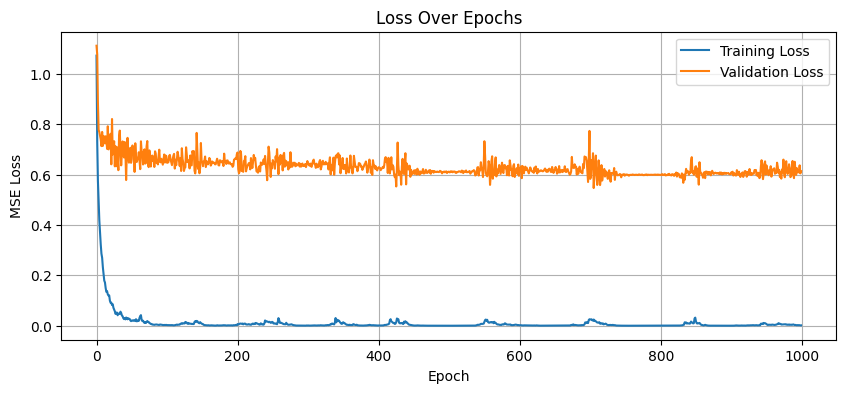

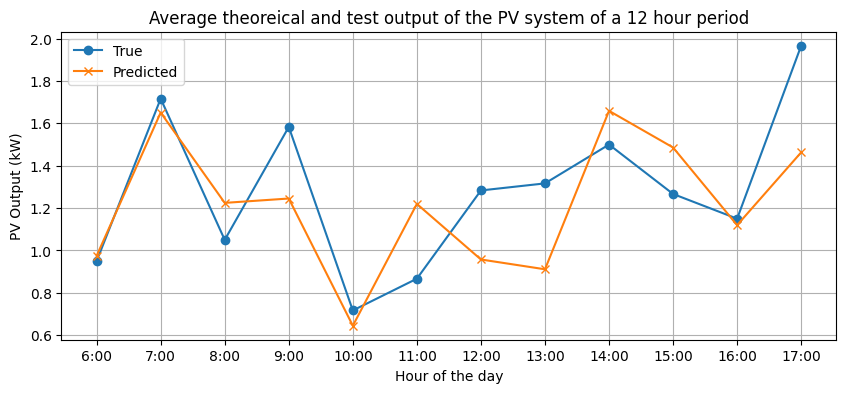

In [7]:

y_test2=y_test.reshape(12,-1)
y_pred2=y_pred.reshape(12,-1)
y_test2=np.average(y_test2,axis=1)
y_pred2=np.average(y_pred2,axis=1)


# --- Step 7: Plot Training & Validation Loss ---
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 8: Plot Last 12 Predictions ---
plt.figure(figsize=(10, 4))
plt.plot(y_test2, label='True', marker='o')
plt.plot(y_pred2, label='Predicted', marker='x')
plt.title('Average theoreical and test output of the PV system of a 12 hour period')
plt.xlabel('Hour of the day')
plt.xticks(np.arange(0, 12, 1), [f"{i+6}:00" for i in range(12)])
plt.ylabel('PV Output (kW)')
plt.legend()
plt.grid(True)
plt.show()


## Predicting the average daily energy for the whole data based purely on the weather data

In [22]:
import pandas as pd
import numpy as np





# Load Data
df_weather = pd.read_csv('Weather_Data.csv')
df_PV_Out = pd.read_excel('Solar.xlsx')

# Clean column names
df_weather.columns = df_weather.columns.str.strip()
df_PV_Out.columns = df_PV_Out.columns.str.strip()

# Convert dates
df_PV_Out['Date'] = pd.to_datetime(df_PV_Out['Date']).dt.date
df_weather['period_end'] = pd.to_datetime(df_weather['period_end'])
df_weather['Date'] = df_weather['period_end'].dt.date

# Filter weather by hour
df_weather = df_weather[df_weather['period_end'].dt.hour.between(6, 17)]

# Match common dates
common_dates = set(df_PV_Out['Date']).intersection(set(df_weather['Date']))
df_weather_filtered = df_weather[df_weather['Date'].isin(common_dates)].drop(columns=['period_end'])
df_PV_filtered = df_PV_Out[df_PV_Out['Date'].isin(common_dates)]

# Sort for alignment
df_weather_filtered = df_weather_filtered.sort_values('Date')
df_PV_filtered = df_PV_filtered.sort_values('Date')

# Drop Date AFTER filtering
df_weather_filtered = df_weather_filtered.drop(columns=['Date'])
df_PV_filtered = df_PV_filtered.drop(columns=['Date'])

pre = Preprocess(latitude=34.2599, longitude=-35.8419)
D=int(len(df_weather_filtered)/12)
irradiation=np.zeros((D,12))
for day in range(0, D, 1):
    for time in range(0, 12, 1):
        irradiation[day,time]=pre.estimate_solar_irradiation(day, time+6, tilt_deg=30, azimuth_deg=230)
irradiation=irradiation.flatten()



# Convert to NumPy
X = df_weather_filtered.to_numpy()
y = df_PV_filtered.to_numpy()

X = np.column_stack((X, irradiation))
# Display or process the filtered DataFrame
y=df_PV_filtered.to_numpy()

y_pred = model.predict(X)
y_pred = y_pred.reshape(12,-1)
irradiation2=irradiation.reshape(12,-1)
irradiation2=np.average(irradiation2,axis=0)
y_pred=np.average(y_pred,axis=0)

35/35 [==============================] - 0s 2ms/step


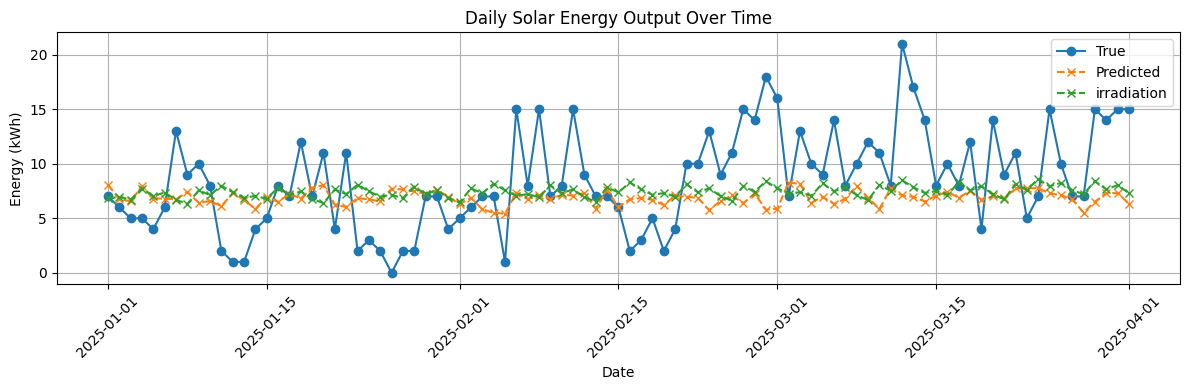

In [23]:
import matplotlib.pyplot as plt

# Assuming df_PV_filtered still has the original Date column before you dropped it
df_temp = df_PV_Out[df_PV_Out['Date'].isin(common_dates)].sort_values('Date')

plt.figure(figsize=(12, 4))
plt.plot(df_temp['Date'], df_temp['Energy'], marker='o',label='True')  # Original data
plt.plot(df_temp['Date'], y_pred/45, marker='x', linestyle='--',label='Predicted')        
plt.plot(df_temp['Date'], irradiation2/45, marker='x', linestyle='--',label='irradiation')           

plt.legend()
plt.title('Daily Solar Energy Output Over Time')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sindy import SINDy
from sklearn.preprocessing import PolynomialFeatures

# Example: Creating a synthetic time series (e.g., a simple damped oscillator)
t = np.linspace(0, 10, 1000)  # Time array
y = np.sin(t) + 0.1 * np.random.randn(1000)  # Sinusoidal data with noise (for example)

# Step 1: Compute the time derivative of the time series (using finite difference)
dt = t[1] - t[0]  # Time step size
dy = np.gradient(y, dt)  # Numerical derivative of y

# Step 2: Construct the library of candidate functions (e.g., polynomial terms)
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(y.reshape(-1, 1))  # Create a polynomial feature set

# Step 3: Fit the SINDy model using sparse regression
model = SINDy()
model.fit(X, dy)

# Step 4: Output the discovered equations
model.print()

# Step 5: Predict the time series using the model
y_pred = model.predict(X)

# Plot the original time series and the predicted time series
plt.figure(figsize=(10, 6))
plt.plot(t, y, label="Original y(t)", linewidth=2)
plt.plot(t, y_pred, label="Predicted y(t) from SINDy", linestyle="--")
plt.legend()
plt.xlabel("Time")
plt.ylabel("y(t)")
plt.title("Time Series Fitting using SINDy")
plt.show()


ModuleNotFoundError: No module named 'sklearn.linear_model.base'

In [30]:
import pandas as pd

# Load Excel file (should be .xlsx if it has multiple sheets)
file_path = 'Data.xlsx'  # Replace with the correct filename if necessary

# Load the second sheet (sheet index 1)
df_weather = pd.read_excel(file_path, sheet_name=1)
# Load the first sheet (sheet index 0)
df_PV_Out = pd.read_excel('Data.xlsx', sheet_name=0)
df_PV_Out = df_PV_Out.drop(columns=['Date','Hour'])
# Convert to NumPy array
data_array = df_PV_Out.to_numpy()

# Ensure 'period_end' is in datetime format
df_weather['period_end'] = pd.to_datetime(df_weather['period_end'])

# Filter rows where time is between 06:00 and 17:00
# filtered_df_weather = df[df['period_end'].dt.hour.between(6, 17)]
filtered_df_weather = df_weather[df_weather['period_end'].dt.hour.between(6, 17)].drop(columns='period_end')
X = np.column_stack((filtered_df_weather.to_numpy(), irradiation))
# Display or process the filtered DataFrame
y=df_PV_Out.to_numpy()


In [34]:
from sklearn.model_selection import train_test_split
from pysr import PySRRegressor

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model on training set
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["sqrt", "log", "exp", "sin", "cos"],
    model_selection="best",  # <<<< ADD THIS LINE
    verbosity=1,
)

model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score
print("R² Score (Test):", r2_score(y_test, y_pred))


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysr\sr.py:2059: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. You should run PySR for more `niterations` to ensure it can find the correct variables, and consider using a larger `maxsize`.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.430e+05
Head worker occupation: 28.8%
Progress: 538 / 1500 total iterations (35.867%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.554e-01  1.594e+01  y = 1.0493
3           9.211e-01  1.831e-02  y = 0.0042933 * x₂₂
4           7.313e-01  2.307e-01  y = exp(0.0035862 * x₂)
5           7.137e-01  2.434e-02  y = exp(sin(-0.034676 * x₂))
6           6.454e-01  1.006e-01  y = exp(sin(sin(x₂ * -0.034565)))
7           6.251e-01  3.187e-02  y = exp(sin(sin(sin(x₂ * -0.034565))))
8           6.200e-01  8.262e-03  y = exp(sin(sin(sin(sin(-0.034565 * x₂)))))
9           6.082e-01  1.915e-02  y = (0.0010549 * (x₆ + (4.2721 * x₂))) + 0.32094
10          6.078e-01  6.347e-04  y = sin(6.633) + ((x₆ + (x₂ * 4.2832)) * 0.0010518)
11          6.009e-01  1.143e-02  y = sin(((0.29899 * x₆) + x₂) * 0.0030437) / sqrt(0.29899)
13          5.889e-0

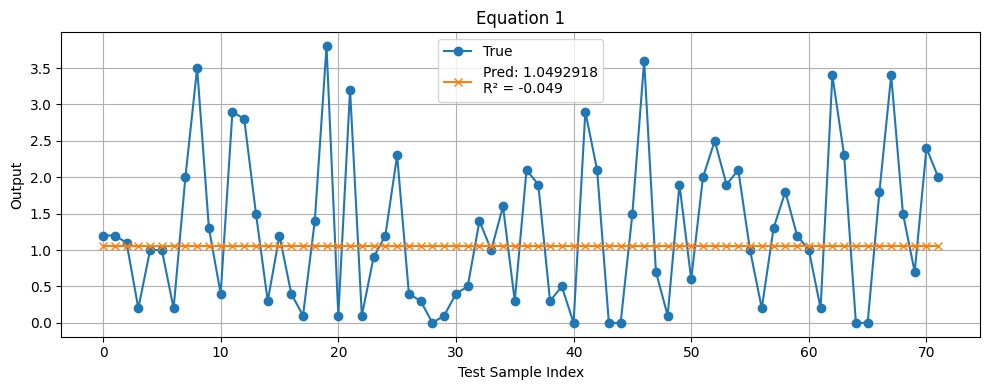

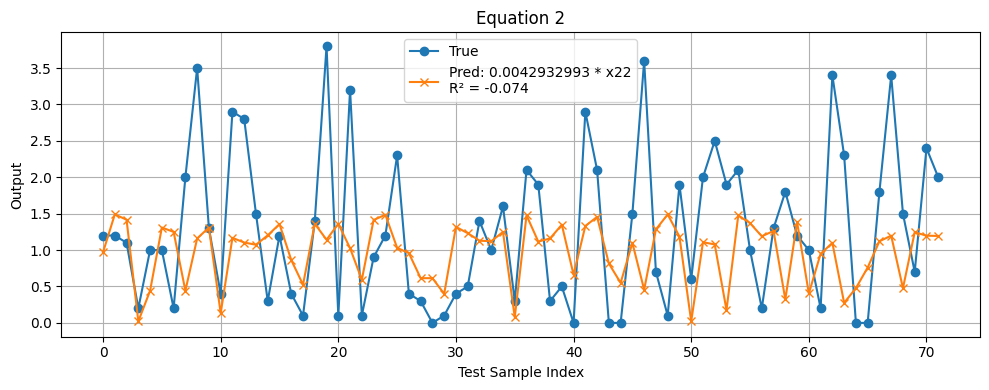

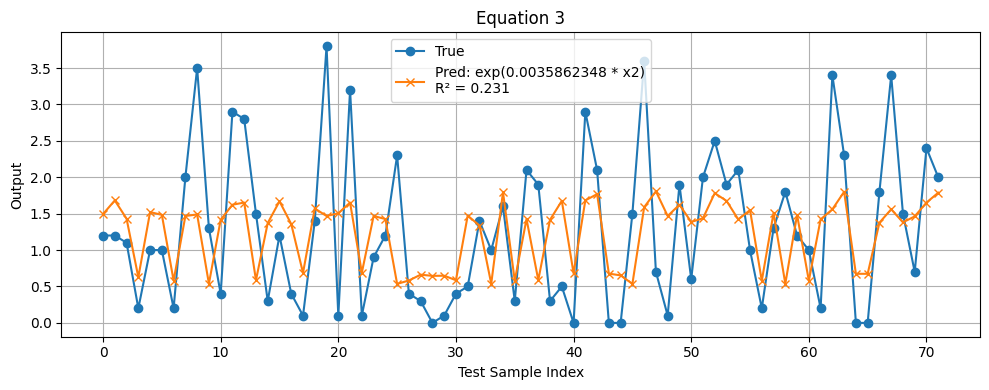

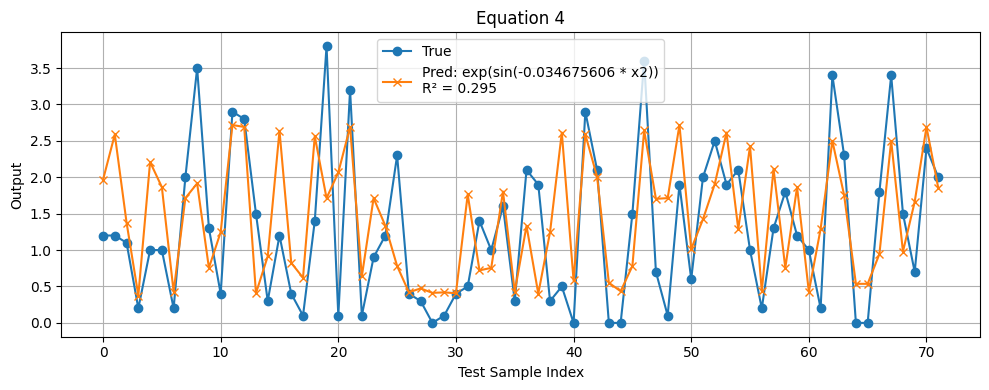

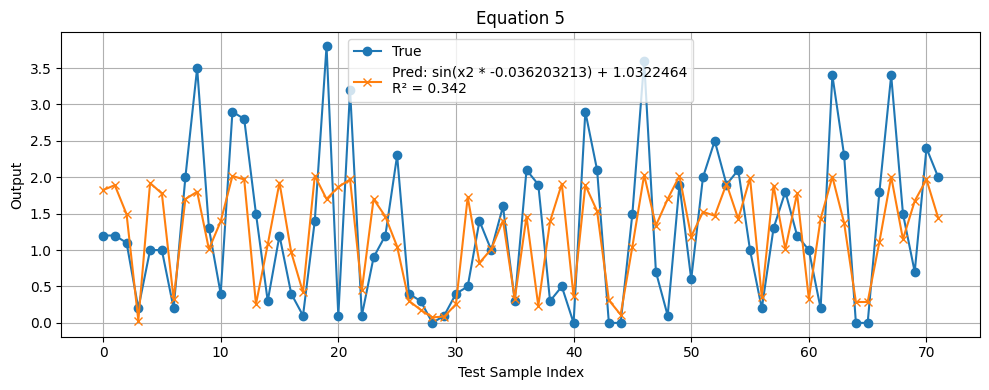

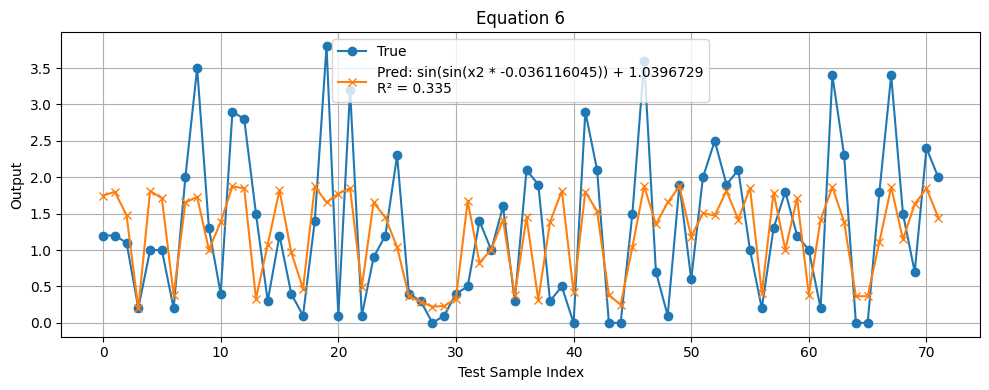

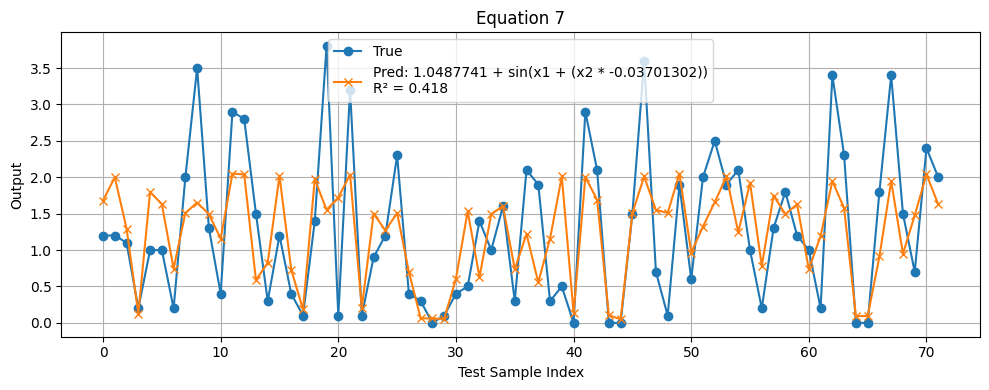

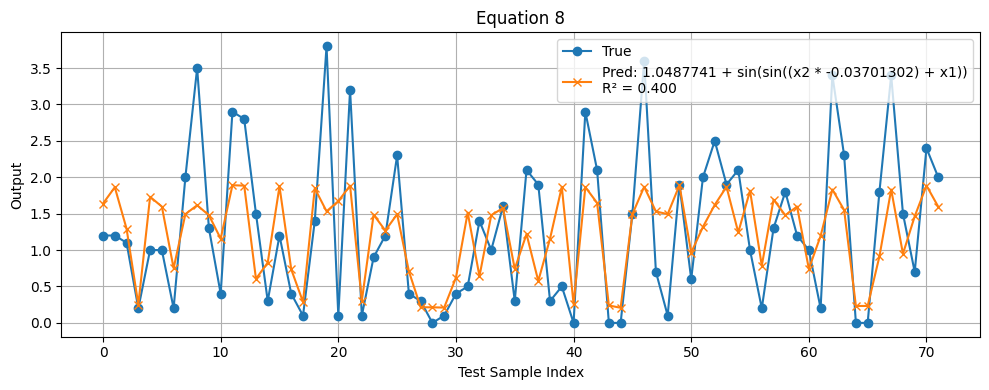

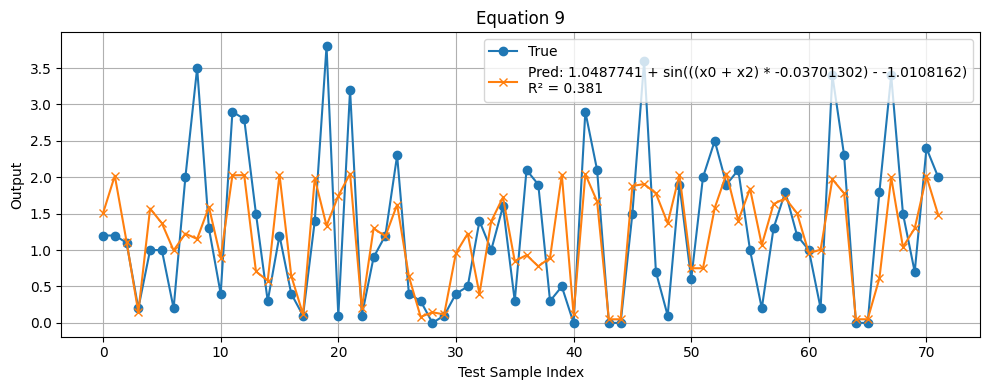

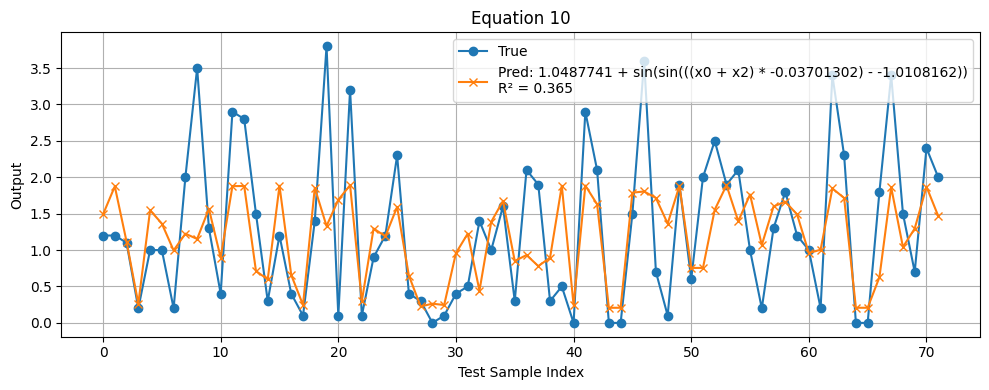

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Get the full list of discovered equations
top_equations = model.equations_.head(10)

# Loop through and plot each equation's predictions
for idx, row in top_equations.iterrows():
    eq_str = row["equation"]
    sympy_fn = row["lambda_format"]  # This is a callable function

    try:
        # Evaluate the model using the symbolic function
        y_pred = sympy_fn(X_test)

        # Plot true vs predicted
        plt.figure(figsize=(10, 4))
        plt.plot(y_test, label="True", marker='o')
        plt.plot(y_pred, label=f"Pred: {eq_str}\nR² = {r2_score(y_test, y_pred):.3f}", marker='x')
        plt.title(f"Equation {idx+1}")
        plt.xlabel("Test Sample Index")
        plt.ylabel("Output")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Skipping equation {idx+1} due to error: {e}")


In [37]:
import re

def count_features(equation_str):
    # Find all x0, x1, ..., xN in the string
    return len(set(re.findall(r'x\d+', equation_str)))

# Add a column with the number of features used
model.equations_["n_features"] = model.equations_["equation"].apply(count_features)

# Find the equation with the most features
most_features_row = model.equations_.loc[model.equations_["n_features"].idxmax()]

# Display it
print("Equation with most features:")
print(most_features_row[["equation", "n_features", "complexity", "score"]])


Equation with most features:
equation      (x25 * (x35 - 0.029317753)) + (2.657491 + sin(...
n_features                                                    4
complexity                                                   14
score                                                  0.017862
Name: 12, dtype: object


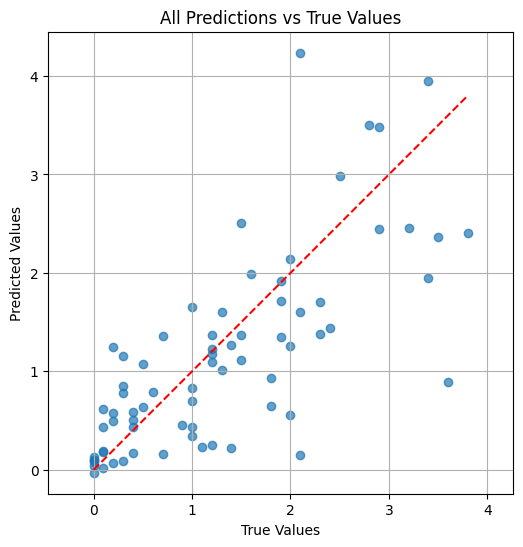

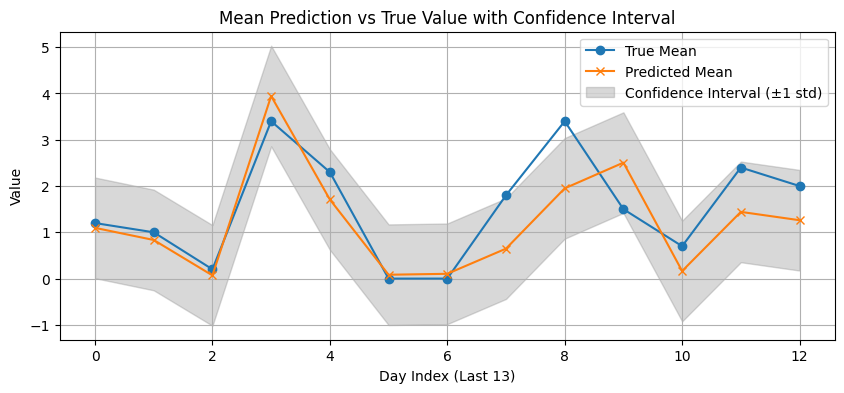

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Scatter Plot of All Predictions ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('All Predictions vs True Values')
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Step 2: Compute Mean & Std Over Last 13 Days ---
# Ensure these are NumPy arrays
y_test = np.asarray(y_test)
y_pred = np.asarray(y_pred)

# Select last 13 entries
y_true_last13 = y_test[-13:]
y_pred_last13 = y_pred[-13:]

# Average per day (assuming 1 value per day, this just shows the mean and std as constant)
y_true_mean = y_true_last13
y_pred_mean = y_pred_last13
y_pred_std = np.full_like(y_pred_mean, np.std(y_pred_last13))  # same std for simplicity

# --- Step 3: Plot Mean and Confidence Interval ---
days = np.arange(len(y_pred_mean))

plt.figure(figsize=(10, 4))
plt.plot(days, y_true_mean, label='True Mean', marker='o')
plt.plot(days, y_pred_mean, label='Predicted Mean', marker='x')

# Confidence interval (±1 std dev)
plt.fill_between(days,
                 y_pred_mean - y_pred_std,
                 y_pred_mean + y_pred_std,
                 color='gray', alpha=0.3, label='Confidence Interval (±1 std)')

plt.xlabel('Day Index (Last 13)')
plt.ylabel('Value')
plt.title('Mean Prediction vs True Value with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
import pysindy as ps

# X is the time series (states), y is dx/dt (derivatives)
# Estimate derivatives if not already known
optimizer = ps.STLSQ(threshold=0.5,alpha=0.1, fit_intercept=True)
differentiation_method = ps.FiniteDifference()
X_fused_train = np.column_stack((X_train, y_train))  # Combine features and target for training
X_fused_test = np.column_stack((X_test, y_test))  # Combine features and target for testing
model_sindy = ps.SINDy(optimizer=optimizer, differentiation_method=differentiation_method)
model_sindy.fit(X_fused_train, t=1.0)  # t is time step

model_sindy.print()
y_pred_sindy = model_sindy.predict(X_fused_test)

# Since SINDy models full dynamics, compare against true derivatives of X_test if available


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


(x0)' = 0.024
(x1)' = 0.000
(x2)' = 75.547 x0 + 3.405 x2 + 2.925 x4 + 24.382 x5 + -21.806 x6 + -12.605 x7 + 3.885 x9 + -4.996 x10 + -41.601 x11 + 35.610 x12 + 316.813 x13 + -23.271 x15 + 0.737 x21 + -2.702 x25 + -1.700 x0^2 + 63.816 x0 x1 + -9.720 x0 x13 + 224.871 x0 x14 + -0.636 x0 x15 + -246.934 x0 x17 + 1833.353 x0 x18 + -40.057 x0 x23 + 88.534 x0 x24 + 2.905 x0 x38 + -10.198 x1 x2 + -9.543 x1 x4 + -64.257 x1 x5 + 57.829 x1 x6 + 35.421 x1 x7 + -106.413 x1 x8 + -11.196 x1 x9 + 15.695 x1 x10 + 121.412 x1 x11 + -103.918 x1 x12 + -25.103 x1 x13 + 92.432 x1 x15 + -6.921 x1 x16 + -1.857 x1 x22 + -793.692 x1 x23 + 32.295 x1 x25 + 0.424 x2 x17 + -2.780 x2 x18 + -1.361 x2 x20 + 4.752 x3 x14 + -30.287 x3 x17 + 229.799 x3 x18 + 3.268 x3 x23 + -4.564 x3 x24 + 3.005 x4 x14 + 3.400 x4 x17 + -25.819 x4 x18 + 23.136 x5 x14 + 29.518 x5 x17 + -236.536 x5 x18 + -11.258 x5 x23 + 12.988 x5 x24 + -2.966 x5 x38 + -9.252 x6 x14 + -19.980 x6 x17 + 160.116 x6 x18 + -1.011 x6 x20 + 8.307 x6 x23 + -9.625 x6 x2

In [25]:
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

# X_df: input features (DataFrame), y_df: target (Series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store symbolic models for each feature
models = []
y_pred_total = np.zeros_like(y_test, dtype=float)

for i, col in enumerate(X_train):
    print(f"\nTraining symbolic model for feature: {col}")
    
    sr = PySRRegressor(
        niterations=40,
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log"],
        model_selection="best",
        loss="loss(x, y) = (x - y)^2",
        verbosity=0,
        random_state=0
    )
    
    # Use only this feature to fit
    Xi_train = X_train[[col]]
    Xi_test = X_test[[col]]
    
    sr.fit(Xi_train, y_train)
    y_pred = sr.predict(Xi_test)
    
    y_pred_total += y_pred  # Sum contribution
    models.append((col, sr))

# Evaluate total prediction
r2 = r2_score(y_test, y_pred_total)
print(f"\nAdditive Symbolic Model R² Score: {r2:.4f}")

# Print expressions
for col, sr in models:
    print(f"\nExpression for {col}:")
    print(sr.get_best())



Training symbolic model for feature: [ 1.50000000e+01  3.00000000e-01 -1.16000000e+02  1.18000000e+02
  8.07000000e+02  5.72000000e+02  6.78000000e+02  2.00000000e+01
  4.00000000e+00  2.71000000e+02  3.35000000e+02  4.55000000e+02
  4.96000000e+02  1.19000000e+01  0.00000000e+00  4.88000000e+01
  8.27800000e+02  8.00000000e-01  1.00000000e-01  0.00000000e+00
  0.00000000e+00  3.20000000e+01  1.60000000e+01  9.00000000e-01
  7.00000000e-01  5.60000000e+01  9.74520595e+02]


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pysr\sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Dataset preview:
   air_temp  albedo  azimuth  clearsky_dhi  clearsky_dni  clearsky_ghi  \
0         2    0.17      -75             0             0             0   
1         2    0.17      -86             0             0             0   
2         2    0.17      -94             0             0             0   
3         2    0.17     -102             0             0             0   
4         2    0.17     -110             4            45             8   

   clearsky_gti  cloud_opacity  dewpoint_temp  dhi  ...  \
0             0           31.6           -0.8    0  ...   
1             0           10.4           -0.8    0  ...   
2             0            4.8           -1.0    0  ...   
3             0            0.4           -1.1    0  ...   
4            18            2.7           -0.9    5  ...   

   snow_water_equivalent  snow_soiling_rooftop  snow_soiling_ground  \
0                    1.6                     0                    0   
1                    1.6                 

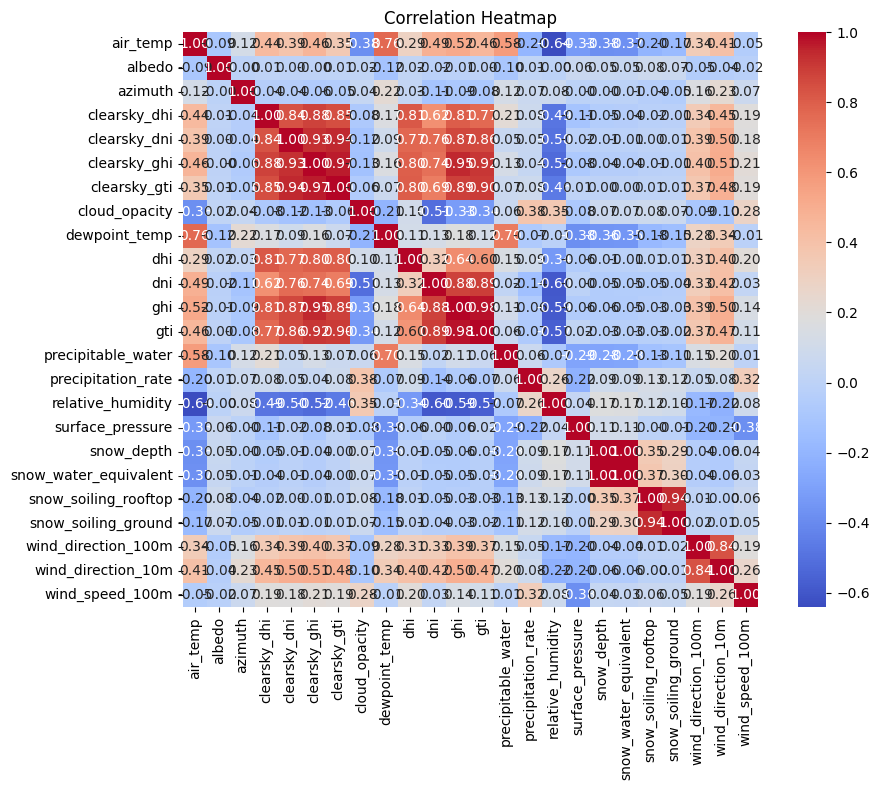

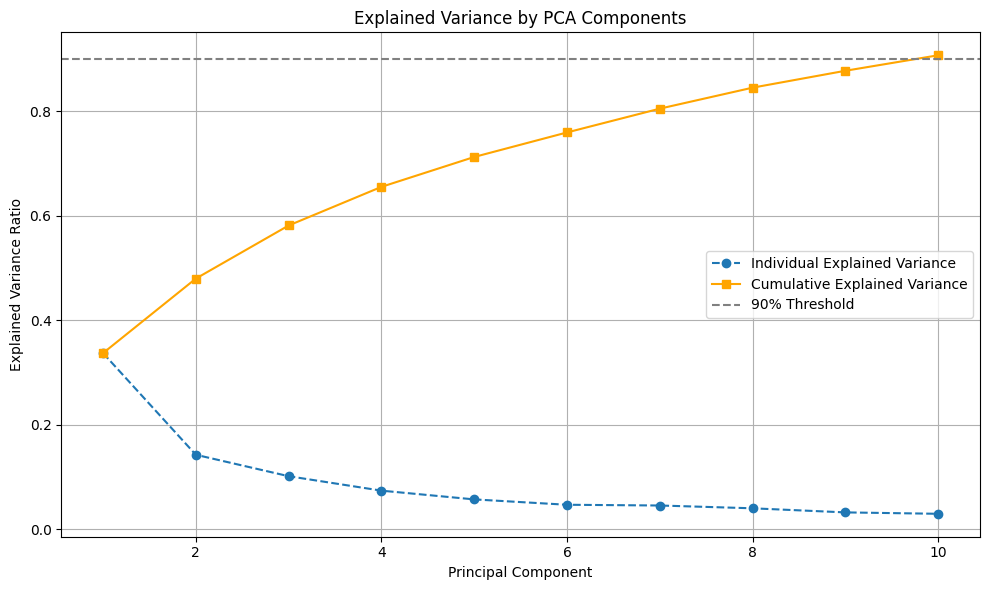


Original shape (after column removal): (36504, 24)
Reduced shape with 90% variance preserved: (36504, 10)

PCA Result Preview:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.429894  2.559064 -1.135147 -0.434183 -1.002864 -1.243136 -0.074241   
1 -3.328460  2.465435 -1.450615 -0.108794 -1.072520 -1.219940 -0.365905   
2 -3.290170  2.436437 -1.554848 -0.016649 -1.067443 -1.228297 -0.449535   
3 -3.242357  2.425981 -1.640423  0.047559 -1.078809 -1.203243 -0.526230   
4 -3.117268  2.502081 -1.617359 -0.067131 -1.023600 -1.212566 -0.534404   

        PC8       PC9      PC10  
0 -0.210895 -0.522162 -0.014119  
1 -0.117584 -0.452432  0.248043  
2 -0.094519 -0.482662  0.299974  
3 -0.083905 -0.507083  0.324537  
4 -0.104996 -0.514234  0.296347  


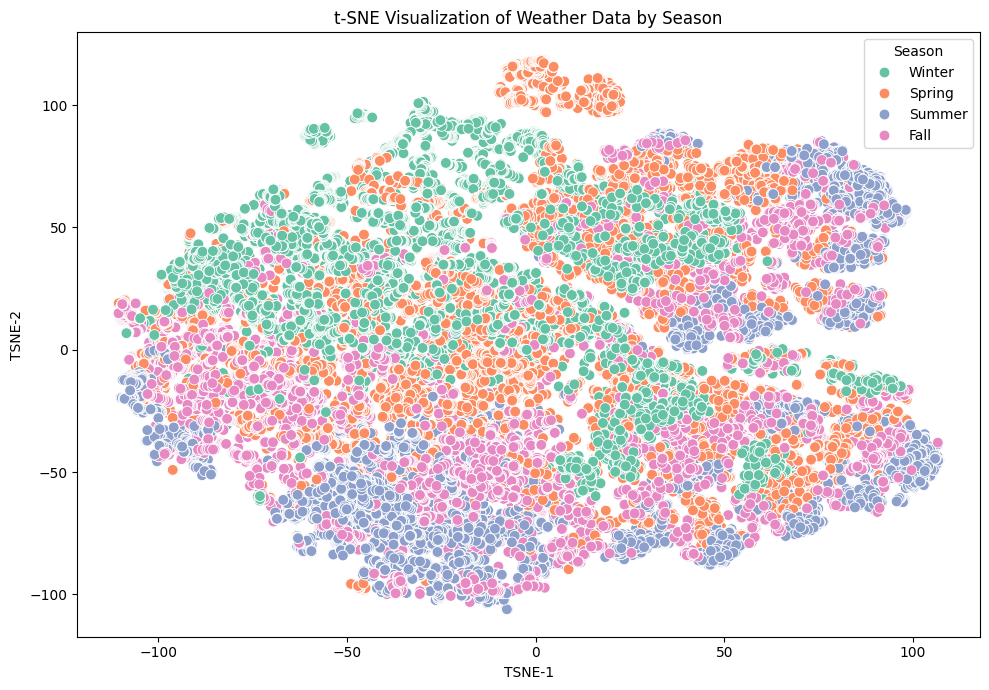

PCA and scaler saved to pca_transform.pkl


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.manifold import TSNE








# Load the dataset
data = pd.read_csv("Weather_Data.csv")

# Display the first few rows (optional)
print("Dataset preview:")
print(data.head())

# Drop non-numeric columns (if any)
numeric_data = data.select_dtypes(include=['number'])

# --- Extract season labels from 'period_end' ---
if 'period_end' in data.columns:
    data['period_end'] = pd.to_datetime(data['period_end'])
    month = data['period_end'].dt.month
else:
    raise ValueError("No 'period_end' column found in dataset.")

# Map months to seasons
def get_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Season'] = month.apply(get_season)

# --- Prepare numeric data ---
numeric_data = data.select_dtypes(include=['number'])

# Remove the last two columns
if numeric_data.shape[1] > 2:
    numeric_data = numeric_data.iloc[:, :-2]
else:
    raise ValueError("Not enough numeric columns to remove the last two.")

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Standardize the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply PCA to preserve 90% of the variance
pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(scaled_data)

# Plot explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
         marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker='s', linestyle='-', label='Cumulative Explained Variance', color='orange')
plt.axhline(y=0.90, color='gray', linestyle='--', label='90% Threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the shape of the PCA result
print(f"\nOriginal shape (after column removal): {scaled_data.shape}")
print(f"Reduced shape with 90% variance preserved: {principal_components.shape}")

# Create a DataFrame for the PCA result (optional)
pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])
print("\nPCA Result Preview:")
print(pca_df.head())

# --- t-SNE dimensionality reduction ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

# Combine t-SNE results with season labels
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE-1', 'TSNE-2'])
tsne_df['Season'] = data['Season']

# --- Plot t-SNE ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x='TSNE-1', y='TSNE-2', hue='Season', palette='Set2', s=60)
plt.title("t-SNE Visualization of Weather Data by Season")
plt.legend(title='Season')
plt.tight_layout()
plt.show()


# Save scaler and PCA to a pickle file
with open("pca_transform.pkl", "wb") as f:
    pickle.dump({'scaler': scaler, 'pca': pca}, f)

print("PCA and scaler saved to pca_transform.pkl")


In [31]:
# Load the scaler and PCA from pickle
with open("pca_transform.pkl", "rb") as f:
    loaded_objects = pickle.load(f)

loaded_scaler = loaded_objects['scaler']
loaded_pca = loaded_objects['pca']

# Example: Transform new data
new_data = pd.read_csv("New_Weather_Data.csv")
new_numeric = new_data.select_dtypes(include=['number']).iloc[:, :-2]  # Remove last 2 columns

# Apply the same transformation
new_scaled = loaded_scaler.transform(new_numeric)
new_pca_result = loaded_pca.transform(new_scaled)

# Create DataFrame (optional)
new_pca_df = pd.DataFrame(new_pca_result, columns=[f"PC{i+1}" for i in range(new_pca_result.shape[1])])
print("\nTransformed new data preview:")
print(new_pca_df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'New_Weather_Data.csv'